In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
import scipy.optimize as optimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

import time

In [49]:
class Circuit:
    def __init__(self,n):
        self.n = n
        self.wires = [Wire(k) for k in range(n)]
        self.gates = []
        
    def addGate(self,g):
        self.gates.append(g)
        for bit in g.bits:
            self.wires[bit].addGate(g)
            
    def appendCircuit(self,circuit, offset=0):
        if offset == 0:
            for gate in circuit.gates:
                self.addGate(gate)
        else:
            pass
    
    def __str__(self):
        string = ""
        for gate in self.gates:
            string = string + str(gate)
            
        return string
        
    def fullStoch(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
        state = state2dist(self.n,state)
        for gate in self.gates:
            state = gate.fullStoch(self.n) @ state
        return state
    
    
    def printWires(self):
        for wire in self.wires:
            print(wire)
            
    def fireShot(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
        else:
            state = np.array(state)
            
        for gate in self.gates:
            gate_state = [state[b] for b in gate.bits]
            gate_state = gate.fireLocal(gate_state)
            for i in range(len(gate_state)):
                state[gate.bits[i]] = gate_state[i]
        return state
        
    def expectationShots(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        runningtotal = self.fireShot()
        for i in range(numshots-1):
            runningtotal = runningtotal + self.fireShot()
        
        return [x / numshots for x in runningtotal]
    
    def shotsDist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = {}
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                ind += 2**k * state[k] 
            ind = int(ind)
            if ind in histstates:
                histstates[ind] += 1
            else:
                histstates[ind] = 1
        for k in histstates:
            histstates[k] /= numshots
        return histstates
    
    def shotsDistHist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = np.zeros(2**self.n)
        xs = np.zeros(2**self.n)
        
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                 ind += 2**k * state[k] 
            histstates[ind] += 1
            xs[ind] = ind
        hist = plt.bar(xs,histstates)
        return hist
        
class Wire:
    def __init__(self,k):
        self.k = k
        self.gates = []
    
    def addGate(self,g):
        self.gates.append(g)
    
    def removeLastGate(self):
        return self.gates.pop()
    
    def __str__(self):
        string = f"[{self.k}]:"
        for gate in self.gates:
            string += str(gate)
        return string

class Gate:
    #assumes if bits = (0,1,2), order is kron(b2,b1,b0).  This follows from c01 gate having control
    #on 0 and target on 1 by convention
    gatecount = 0

    def __init__(self,matrix,bits):
        assert(matrix.shape == (2**len(bits),2**len(bits)))
        self.matrix = matrix
        self.bits = bits
        self.id = Gate.gatecount
        Gate.gatecount += 1
        
    def __str__(self):
        str = ""
        if len(self.bits) == 1:
            str = f"-a{self.id}"
        else:
            str = f"-b{self.id}"
        return str
    
    
    def fireLocal(self,state):
        #TODO: verify that this is resilient to weird ordered qubits
        state_dist = state2dist(len(state),state)
        new_dist = np.dot(self.matrix,state_dist)
        new_state = sampledist(len(state),new_dist)
        return new_state;
    
    def fullStoch(self,n):
        #TODO: optimize for adjacent bit states (no swaps required)
        #first construct hamiltonian operating on first len(bits) qubits, then swap bits to fit order
        stoch = self.matrix
        for i in range(n - len(self.bits)):
            stoch = np.kron([[1,0],[0,1]],stoch)
            
        swaps = Gate._swapcircuit(self,n)
        if len(swaps):
            stoch = np.dot(stoch, np.transpose(swaps))
            stoch = np.dot(swaps, stoch)
            
        return stoch
    
    def _swapcircuit(self,n):
        swaplist = Gate._bubbleSortOperations(self.bits) 
        sortedbits = sorted(self.bits)
        for i in range(len(sortedbits)-1,-1,-1):
            if not (i == sortedbits[i]):
                swaplist.append((i,sortedbits[i]))
        return Gate._swapStoch(self,n,swaplist)
    
    
    def _swapStoch(self,n,swaplist):
        swapMatrix =  []
        if not (len(swaplist) == 0):
            swapMatrix = np.eye(2**n)
            for swapbits in swaplist:
                swapMatrix = np.dot(Gate._generateSwapMatrix(n,swapbits),swapMatrix)
        return swapMatrix
    
    def _generateSwapMatrix(n,swapbits):
        N = 2**n
        swapMat = np.zeros((N,N))
        for i in range(N):
            mask1 = i >> swapbits[0] & 1
            mask2 = i >> swapbits[1] & 1
            xor = mask1 ^ mask2
            xor = xor << swapbits[0] | xor << swapbits[1]
            j = i ^ xor
            swapMat[i,j] = 1
        return swapMat
    
    def _bubbleSortOperations(bits):
        issorted = False
        swaplist = []
        while not issorted:
            issorted = True
            for i in range(len(bits) - 1):
                if bits[i] > bits[i+1]:
                    temp = bits[i]
                    bits[i] = bits[i+1]
                    bits[i+1] = temp
                    issorted = False
                    swaplist.append((i,i+1))
        return swaplist

def state2dist(n,state):
    ##reverse marginal calculation, assuming no correlation
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #simialr to a bit string
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    dist = np.zeros(2**n)
    for i in range(2**n):
        iprob = 1;
        for k in range(n):
            if (1 << k) & i:
                iprob *= state[k]
            else:
                iprob *= 1.0 - state[k]
        dist[i] = iprob
    return dist
            
        
def dist2state(n,dist):
    ##Effectively a marginal calculation
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #similar to a bit string
    outstate = np.zeros(n);
    for i in range(2**n):
        for k in range(n):
            outstate[k] += (((1 << k) & i)>>k) * dist[i]
            
    return outstate
            
def sampledist(n,dist):
    choices = [i for i in range(2**n)]
    choice = np.random.choice(choices,p=dist)
    state = np.zeros(n)
    for i in range(n):
        state[i] += (((1 << i) & choice) >> i)
    return state

def randomStochMatrix(n):
    mat = np.random.rand(2**n,2**n)
    mat = mat/mat.sum(axis = 0)
    return mat

def stateHistogram(n,dist):
    assert (type(dist) == np.ndarray or type(dist) == dict), "Invalid type for plotting.  Must be np.ndarray or dict"
    if type(dist) == dict:
        xs = [k for k in dist]
        xs.sort()
        ys = [dist[k] for k in xs]
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("Sampled Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig
    else:
        xs = dist.nonzero()
        ys = np.array(dist[xs])
        xs = xs[0]
        print(xs)
        print()
        print(ys)
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("True Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig

def randomConnectedGraph(n,k=3):
    #returns a random connected 3-regular graph
    G = nx.generators.random_graphs.random_regular_graph(k,n)
    while not nx.is_connected(G):
        G = nx.generators.random_graphs.random_regular_graph(k,n);
        
    #relabelling to fix read/write issues (reads nodes in different order producing wrong
    #adjacency matrix)
    mapping = dict(zip(G,sorted(G)))
    G = nx.relabel_nodes(G, mapping)
    return G

def readGraph(path):
    file = open(path,'r')
    G = nx.Graph()
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            G.add_node(int(labels[0]))
    file.seek(0)
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            edges = [(int(labels[0]),int(labels[i])) for i in range(1,len(labels))]
            G.add_edges_from(edges)
    file.close()
    return G

def writeGraph(G,path):
    nx.write_adjlist(G,path)
    
def graphMatrix(G):
    return nx.adjacency_matrix(G)

def graphCutInt(G,integer):
    n = G.number_of_nodes()
    vec = np.array([(integer & 1 << i) >> i for i in range(n)])
    return graphCutBin(G,vec)

def graphCutBin(G,vec):
    vec = np.array(vec)
    vec = 1 - 2*vec
    return graphCutIsing(G,vec)

def graphCutIsing(G,vec):
    #use mat.size instead of np.sum(mat) for speed. since all weights are 1 in matrix.
    vec = np.array([vec])
    mat = graphMatrix(G)
    return (mat.size - (vec @ mat @ vec.T)[0][0])/4

def bruteMaxGraphCut(G):
    n = G.number_of_nodes()
    maxCutInt = 0
    maxCutVal = 0
    for i in range(2**n):
        c = graphCutInt(G, i)
        if(c > maxCutVal):
            maxCutInt = i
            maxCutVal = c
    return maxCutInt,maxCutVal

def getAnsatzGate2bit(b1,b2,gamma):
    if gamma == 0.:
        mat = np.identity(4)
    elif gamma == np.inf:
        mat = np.array(\
        [[0,0,0,0 ],\
         [.5,1,0,.5],\
         [.5,0,1,.5],\
         [0,0,0,0]])
    else:
        P = np.array(\
        [[0,0,0,0 ],\
         [.5,1,0,.5],\
         [.5,0,1,.5],\
         [0,0,0,0]])
        mat = sp.linalg.expm(-gamma * (np.identity(4) - P))
    gate = Gate(mat,[b1,b2])
    return gate
    
def getAnsatzGate1bit(b,theta):
    #cases = 'default'
    mat = np.array([[np.cos(theta)**2, np.sin(theta)**2],
                    [np.sin(theta)**2, np.cos(theta)**2]])
    gate = Gate(mat,[b])
    return gate

def getEdgeColoring(G):
    lineGraph = nx.generators.line.line_graph(G)
    colors = nx.algorithms.greedy_color(lineGraph)
    return colors

def colors2dict(colors):
    d = dict()
    for edge in colors.keys():
        if colors[edge] in d.keys():
            d[colors[edge]].append(edge)
        else:
            d[colors[edge]] = [edge]
    return d

def getEmbeddedCircuit(G,theta,gamma,case='default'):
    ##cases: default, sorted, largest_only
    colors = getEdgeColoring(G);
    colordict = colors2dict(colors)
    n = G.number_of_nodes()
    circ = Circuit(n)
    #TODO: Add capability of random shuffling of keys for random layer ordering
    #add coinflip gates
    for bit in range(n):
        gate = getAnsatzGate1bit(bit,theta)
        circ.addGate(gate)
    
    #adding 2 pbit ansatz gates
    layerlist = []
    if case == 'largest_only':
        color_sizes = np.array([len(colordict[color]) for color in colordict.keys()])
        color_order = np.argsort(color_sizes)
        max_color = color_order[-1]
        layerlist = [max_color]
        for edge in colordict[max_color]:
            gate = getAnsatzGate2bit(*edge,gamma)
            circ.addGate(gate)
    elif case == 'sorted':
        color_sizes = np.array([len(colordict[color]) for color in colordict.keys()])
        color_order = np.argsort(color_sizes)
        for color in color_order:
            layerlist = colordict[color]
            for edge in layerlist:
                gate = getAnsatzGate2bit(*edge,gamma)
                circ.addGate(gate)
    else:
        for color in colordict.keys():
            layerlist = colordict[color]
            for edge in layerlist:
                gate = getAnsatzGate2bit(*edge,gamma)
                circ.addGate(gate)
    return circ

def getLiteEmbeddedCircuit(G,theta,gamma,case='default'):
    ##cases: default, sorted, largest_only
    colors = getEdgeColoring(G);
    colordict = colors2dict(colors)
    n = G.number_of_nodes()
    circ = Circuit(n)
    
    #adding 2 pbit ansatz gates
    layerlist = []
    if case == 'largest_only':
        color_sizes = np.array([len(colordict[color]) for color in colordict.keys()])
        color_order = np.argsort(color_sizes)
        max_color = color_order[-1]
        layerlist = [max_color]
        for edge in colordict[max_color]:
            gate = getAnsatzGate2bit(*edge,gamma)
            circ.addGate(gate)
    elif case == 'sorted':
        color_sizes = np.array([len(colordict[color]) for color in colordict.keys()])
        color_order = np.argsort(color_sizes)
        for color in color_order:
            layerlist = colordict[color]
            for edge in layerlist:
                gate = getAnsatzGate2bit(*edge,gamma)
                circ.addGate(gate)
    elif case == 'random':
        ##TODO add shuffling
        color_sizes = np.array([len(colordict[color]) for color in colordict.keys()])
        color_order = [i for i in range(len(colordict.keys()))]
        np.random.shuffle(color_order)
        for color in color_order:
            layerlist = colordict[color]
            for edge in layerlist:
                gate = getAnsatzGate2bit(*edge,gamma)
                circ.addGate(gate)
    else:
        for color in colordict.keys():
            layerlist = colordict[color]
            for edge in layerlist:
                gate = getAnsatzGate2bit(*edge,gamma)
                circ.addGate(gate)
    return circ


def computeCircuitCuts(circ, G, numshots):
    #dist = circ.shotsDist(numshots);
    #distkeys = dist.keys()
    #expected_cut = 0;
    #for integer in distkeys:
    #    expected_cut += dist[integer] * graphCutInt(G,integer)
    #return expected_cut
    expected_cut = 0
    for i in range(numshots):
        state = circ.fireShot()
        expected_cut += graphCutBin(G,state)/numshots
    return expected_cut


def _optimization_function(x, *params):
    G, numshots, depth = params
    thetas = x[:depth]
    gammas = x[depth:]
    n = G.number_of_nodes()
    circ = Circuit(n)
    for i in range(depth):
        circ.appendCircuit(getEmbeddedCircuit(G,thetas[i],gammas[i]))
    return -computeCircuitCuts(circ,G,numshots) #scipy optimizers minimize, so give -(func) for max
    
def optimizeThetaGamma(G,numshots,depth,bounds,Ns,full_output=True):
    f = _optimization_function
    thetaLower = bounds[0][0]
    thetaUpper = bounds[0][1]
    gammaLower = bounds[1][0]
    gammaUpper = bounds[1][1]
    
    thetaN = Ns[0]
    gammaN = Ns[1]
    
    thetaStep = (thetaUpper - thetaLower)/(thetaN - 1)
    gammaStep = (gammaUpper - gammaLower)/(gammaN - 1)
    
    
    thetas = np.linspace(thetaLower,thetaUpper, num = thetaN)
    gammas = np.linspace(gammaLower,gammaUpper, num = gammaN)
    
    #weird upper limit is to work around python slice weirdness to get proper gridpoints
    theta_ranges = [slice(thetaLower,thetaUpper+thetaStep/2,thetaStep) for i in range(depth)]
    gamma_ranges = [slice(gammaLower,gammaUpper+gammaStep/2,gammaStep) for i in range(depth)]
    
    rranges = (*theta_ranges, *gamma_ranges)
    params = (G, numshots, depth)
    
    opt = optimize.brute(_optimization_function, rranges, args=params,finish=None, full_output=full_output)
    return opt

def optimizeThetaGammaBAB(G,numshots,depth,bounds,Ns,full_output=True):
    f = _optimization_function
    thetaLower = bounds[0][0]
    thetaUpper = bounds[0][1]
    gammaLower = bounds[1][0]
    gammaUpper = bounds[1][1]
    
    thetaN = Ns[0]
    gammaN = Ns[1]
    
    thetaStep = (thetaUpper - thetaLower)/(thetaN - 1)
    gammaStep = (gammaUpper - gammaLower)/(gammaN - 1)
    
    
    thetas = np.linspace(thetaLower,thetaUpper, num = thetaN)
    gammas = np.linspace(gammaLower,gammaUpper, num = gammaN)
    
    theta_0 = slice(np.pi/4, np.pi/4 + np.finfo(float).eps, thetaStep)
    #weird upper limit is to work around python slice weirdness to get proper gridpoints
    theta_ranges = [slice(thetaLower,thetaUpper+thetaStep/2,thetaStep) for i in range(depth-1)]
    gamma_ranges = [slice(gammaLower,gammaUpper+gammaStep/2,gammaStep) for i in range(depth)]
    
    rranges = (theta_0, *theta_ranges, *gamma_ranges)
    params = (G, numshots, depth)
    print('params: ', params)
    print('rranges: ', rranges)
    
    opt = optimize.brute(_optimization_function, rranges, args=params,finish=None, full_output=full_output)
    return opt
    

def plotThetaGammaHeatmap(G,numshots,bounds,Ns,title_prefix=""):
    #takes quite a bit of time to run.
    #As a rule of thumb, it takes about half a seconds for 1000 shots on a 4 k4 graph.
    #This will scale linearly with the vertices in the graph and linearly for the number of shots.
    depth = 1
    opt = optimizeThetaGamma(G,numshots,depth,bounds,Ns)
    bestTheta,bestGamma = opt[0]
    bestCut = -opt[1]
    Thetas, Gammas = opt[2]
    Cuts = -opt[3]
    #cuts = np.array([[computeCircuitCuts(getEmbeddedCircuit(G,theta,gamma),G,numshots) \
    #                  for theta in thetas] for gamma in gammas])
    
    #print(len(Cuts))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(Thetas, Gammas, Cuts, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    
    
    #maxInt,maxCut = bruteMaxGraphCut(G);
    n = G.number_of_nodes()
    maxCut = n * 3/2 #Using full edge cut as upper bound
    ax.set_zlim(0, maxCut)
    title = None
    if title_prefix == "":
        title = "Expected Max Cut Heatmap, 1 Layer |V| = "+str(n)+"\nApprox. Ratio: "+str(bestCut/maxCut)
    else:
        title = title_prefix + "\n |V| = "+str(n)+"; Approx. Ratio: "+str(bestCut/maxCut)
    ax.set_title(title)
    ax.set_xlabel("theta")
    ax.set_ylabel("gamma")
    ax.set_zlabel("cut value")
    
    fig.colorbar(surf)
    
    return fig

def plotDepthPerformance(G,numshots,depths,bounds,Ns,title_prefix=""):
    cuts = np.zeros(len(depths))
    n = G.number_of_nodes()
    for i in range(len(depths)):
        depth = depths[i]
        print("on depth ", depth)
        x0 = optimizeThetaGamma(G,numshots,depth,bounds,Ns,full_output=False)
        params = (G, numshots, depth)
        cuts[i] = _optimization_function(x0,*params)
        
    ratios = cuts/(3*n/2)
    fig = plt.figure()
    
    if title_prefix == "":
        title = "Approximation Ratios by depth for |V| = "+str(n)
    else:
        title = title_prefix + ", |V| = "+str(n)
    
    plt.scatter(depth,ratios)
    plt.title(title)
    plt.xlabel("depth")
    plt.ylabel("Approximation Ratio")
    return fig



In [22]:
G = randomConnectedGraph(64)
numshots = 100
bounds = [(0,np.pi/2), (0.00,4)]
Ns = [13, 40]
depth = 2
opt = optimizeThetaGamma(G,numshots,depth,bounds,Ns)
print(opt)
theta, gamma = opt[0]
best = opt[1]
grid = opt[2]
funcs = opt[3]
print("Best (Theta, Gamma): (", theta, ", ", gamma, ")")
print("Best Cut: ", opt[1])

Thetas:  [0. 0.]
Gammas:  [0. 0.]

[0]:-a0-b70-b98-b129-a160-b230-b258-b289
[1]:-a1-b70-b97-b130-a161-b230-b257-b290
[2]:-a2-b65-b100-b140-a162-b225-b260-b300
[3]:-a3-b65-b93-b133-a163-b225-b253-b293
[4]:-a4-b67-b112-b119-a164-b227-b272-b279
[5]:-a5-b84-b112-b134-a165-b244-b272-b294
[6]:-a6-b66-b139-b154-a166-b226-b299-b314
[7]:-a7-b77-b111-b139-a167-b237-b271-b299
[8]:-a8-b79-b114-b150-a168-b239-b274-b310
[9]:-a9-b88-b134-b150-a169-b248-b294-b310
[10]:-a10-b88-b118-b137-a170-b248-b278-b297
[11]:-a11-b72-b103-b123-a171-b232-b263-b283
[12]:-a12-b72-b99-b154-a172-b232-b259-b314
[13]:-a13-b75-b105-b131-a173-b235-b265-b291
[14]:-a14-b75-b113-b155-a174-b235-b273-b315
[15]:-a15-b69-b96-b153-a175-b229-b256-b313
[16]:-a16-b86-b135-b153-a176-b246-b295-b313
[17]:-a17-b68-b95-b158-a177-b228-b255-b318
[18]:-a18-b110-b130-b158-a178-b270-b290-b318
[19]:-a19-b97-b122-b159-a179-b257-b282-b319
[20]:-a20-b74-b121-b146-a180-b234-b281-b306
[21]:-a21-b74-b115-b136-a181-b234-b275-b296
[22]:-a22-b76-b109-b13

Thetas:  [0. 0.]
Gammas:  [0.         0.30769231]

[0]:-a960-b1030-b1058-b1089-a1120-b1190-b1218-b1249
[1]:-a961-b1030-b1057-b1090-a1121-b1190-b1217-b1250
[2]:-a962-b1025-b1060-b1100-a1122-b1185-b1220-b1260
[3]:-a963-b1025-b1053-b1093-a1123-b1185-b1213-b1253
[4]:-a964-b1027-b1072-b1079-a1124-b1187-b1232-b1239
[5]:-a965-b1044-b1072-b1094-a1125-b1204-b1232-b1254
[6]:-a966-b1026-b1099-b1114-a1126-b1186-b1259-b1274
[7]:-a967-b1037-b1071-b1099-a1127-b1197-b1231-b1259
[8]:-a968-b1039-b1074-b1110-a1128-b1199-b1234-b1270
[9]:-a969-b1048-b1094-b1110-a1129-b1208-b1254-b1270
[10]:-a970-b1048-b1078-b1097-a1130-b1208-b1238-b1257
[11]:-a971-b1032-b1063-b1083-a1131-b1192-b1223-b1243
[12]:-a972-b1032-b1059-b1114-a1132-b1192-b1219-b1274
[13]:-a973-b1035-b1065-b1091-a1133-b1195-b1225-b1251
[14]:-a974-b1035-b1073-b1115-a1134-b1195-b1233-b1275
[15]:-a975-b1029-b1056-b1113-a1135-b1189-b1216-b1273
[16]:-a976-b1046-b1095-b1113-a1136-b1206-b1255-b1273
[17]:-a977-b1028-b1055-b1118-a1137-b1188-b1215-b1278
[18]:

Thetas:  [0. 0.]
Gammas:  [0.         0.61538462]

[0]:-a1920-b1990-b2018-b2049-a2080-b2150-b2178-b2209
[1]:-a1921-b1990-b2017-b2050-a2081-b2150-b2177-b2210
[2]:-a1922-b1985-b2020-b2060-a2082-b2145-b2180-b2220
[3]:-a1923-b1985-b2013-b2053-a2083-b2145-b2173-b2213
[4]:-a1924-b1987-b2032-b2039-a2084-b2147-b2192-b2199
[5]:-a1925-b2004-b2032-b2054-a2085-b2164-b2192-b2214
[6]:-a1926-b1986-b2059-b2074-a2086-b2146-b2219-b2234
[7]:-a1927-b1997-b2031-b2059-a2087-b2157-b2191-b2219
[8]:-a1928-b1999-b2034-b2070-a2088-b2159-b2194-b2230
[9]:-a1929-b2008-b2054-b2070-a2089-b2168-b2214-b2230
[10]:-a1930-b2008-b2038-b2057-a2090-b2168-b2198-b2217
[11]:-a1931-b1992-b2023-b2043-a2091-b2152-b2183-b2203
[12]:-a1932-b1992-b2019-b2074-a2092-b2152-b2179-b2234
[13]:-a1933-b1995-b2025-b2051-a2093-b2155-b2185-b2211
[14]:-a1934-b1995-b2033-b2075-a2094-b2155-b2193-b2235
[15]:-a1935-b1989-b2016-b2073-a2095-b2149-b2176-b2233
[16]:-a1936-b2006-b2055-b2073-a2096-b2166-b2215-b2233
[17]:-a1937-b1988-b2015-b2078-a2097-b2148

KeyboardInterrupt: 

In [5]:
G2 = randomConnectedGraph(64)
numshots = 100
bounds = [(0,np.pi/2), (0.00,4)]
#Ns = [13, 20]
Ns = [13,20]
depth = 2
tic = time.perf_counter()
opt2 = optimizeThetaGammaBAB(G2,numshots,depth,bounds,Ns)
toc = time.perf_counter()
print("time to run: ", toc - tic, " seconds")
print(opt2)
#theta2, gamma2 = opt[0]
best2 = opt2[1]
#grid2 = opt[2]
#funcs2 = opt[3]
#print("Best (Theta, Gamma): (", theta, ", ", gamma, ")")
print("Best Cut: ", best2)

params:  (<networkx.classes.graph.Graph object at 0x7943094f3290>, 100, 2)
rranges:  (slice(0.7853981633974483, 0.7853981633974485, 0.1308996938995747), slice(0, 1.6362461737446838, 0.1308996938995747), slice(0.0, 4.105263157894737, 0.21052631578947367), slice(0.0, 4.105263157894737, 0.21052631578947367))
time to run:  7161.354743744014  seconds
(array([0.78539816, 1.57079633, 2.31578947, 3.57894737]), -72.08999999999999, array([[[[[0.78539816, 0.78539816, 0.78539816, ..., 0.78539816,
           0.78539816, 0.78539816],
          [0.78539816, 0.78539816, 0.78539816, ..., 0.78539816,
           0.78539816, 0.78539816],
          [0.78539816, 0.78539816, 0.78539816, ..., 0.78539816,
           0.78539816, 0.78539816],
          ...,
          [0.78539816, 0.78539816, 0.78539816, ..., 0.78539816,
           0.78539816, 0.78539816],
          [0.78539816, 0.78539816, 0.78539816, ..., 0.78539816,
           0.78539816, 0.78539816],
          [0.78539816, 0.78539816, 0.78539816, ..., 0.78539

Gates:
-b0-a1-b2

Wires:
[0]:-b0-b2
[1]:-b0-a1
[2]:-b2
[3]:
[4]:

Shot Distribution:
[1, 5, 0, 4, 7, 3, 6, 2]
[0, 1, 2, 3, 4, 5, 6, 7]
00000  =>  0.1163
00001  =>  0.2072
00010  =>  0.0398
00011  =>  0.0563
00100  =>  0.2353
00101  =>  0.2269
00110  =>  0.0565
00111  =>  0.0617

True Distribution:
00000  =>  0.11780230433011861
00001  =>  0.21456489574708315
00010  =>  0.03694091172003953
00011  =>  0.05355394322992482
00100  =>  0.2302664621078463
00101  =>  0.2237473215899128
00110  =>  0.057000538980290935
00111  =>  0.06612362229478386
[0 1 2 3 4 5 6 7]

[0.1178023  0.2145649  0.03694091 0.05355394 0.23026646 0.22374732
 0.05700054 0.06612362]

Graph Examples
Graph (original):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Graph (from file):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Cut Examples on Crossed Square Graph:
[1, 1, 1, 1]
cut:  0.0

[0, 0, 0, 0]
cut:  0.0

[1, 1, 0, 0

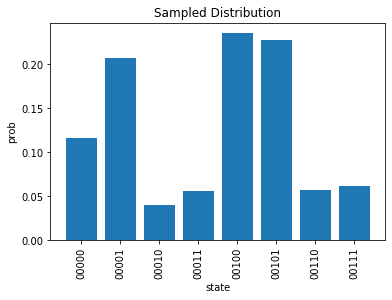

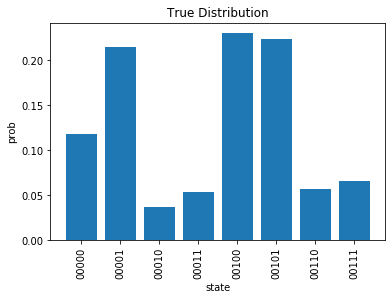

In [27]:
#convergence checking for V&V
n = 5
circ = Circuit(n)
m1 = randomStochMatrix(2)
g1 = Gate(m1,[0,1])

m2 = randomStochMatrix(1)
g2 = Gate(m2,[1])

m3 = randomStochMatrix(2)
g3 = Gate(m3,[0,2])

circ.addGate(g1)
circ.addGate(g2)
circ.addGate(g3)

print("Gates:")
print(circ)
print()

print("Wires:")
circ.printWires()

print()

print("Shot Distribution:")
dist = circ.shotsDist(10000)

distkeys = [k for k in dist]
print(distkeys)
distkeys.sort()
print(distkeys)
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k, binformat) , " => ", dist[k])

print()
print("True Distribution:")
state = circ.fullStoch()
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k,binformat), " => ", state[k])

stateHistogram(n,dist)
stateHistogram(n,state)

## Graph Example
random.seed(123)
np.random.seed(456)
print()
print("Graph Examples")
G_8 = randomConnectedGraph(8)
print("Graph (original):")
print(G_8.edges)

writeGraph(G_8,"graph_example.adjlist")
G_8_read = readGraph("graph_example.adjlist")

print("Graph (from file):")
print(G_8_read.edges)

G4 = randomConnectedGraph(4)
print("Cut Examples on Crossed Square Graph:")

vec = [1,1,1,1]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [0,0,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,1,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,-1,1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))
print()

vec = [1,-1,-1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))

##Demonstrating ansatz circuits:
g_1pbit = getAnsatzGate1bit(0, np.pi/2)
g_2pbit = getAnsatzGate2bit(0,1,gamma = 100)

print("1 pbit ansatz matrix, theta = pi/2")
print(g_1pbit.matrix)
print("2 pbit ansatz matrix, gamma = 100")
print(g_2pbit.matrix)

#Demonstrating graph embedding for K4 graph
print("K4 circuit embedding:")
k4 = randomConnectedGraph(4)
circ = getEmbeddedCircuit(k4,theta=np.pi/2, gamma=100)
circ.printWires()

#Demonstrating circuit appending
circ2 = getEmbeddedCircuit(k4,theta=0,gamma=10)
circ.appendCircuit(circ2)

print()
print()
print("Appending another circuit")
circ.printWires()

circ = getEmbeddedCircuit(k4,theta=np.pi/2, gamma=1)
expected_cut = computeCircuitCuts(circ,k4,1000)
print("expected cut: ", expected_cut)

5
Time to run 6 vertices and 5x5 grid:  14.046304818009958  seconds


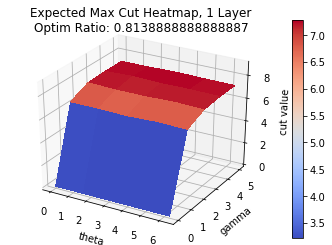

In [160]:
#plotThetaGammaHeatmap(k4)
plotgraph = randomConnectedGraph(6)
bounds = [(0,2*np.pi), (0,5)]
Ns = [5, 5];
tic = time.perf_counter()
fig = plotThetaGammaHeatmap(plotgraph,1000,bounds,Ns)
toc = time.perf_counter()

print("Time to run 6 vertices and 5x5 grid: ", toc - tic, " seconds")

fig.savefig('figures/testfig.png')

50
50
50
time to generate all 6 vertex plots:  4338.276594438998  seconds
50
50
50
time to generate all 8 vertex plots:  5988.065261335985  seconds


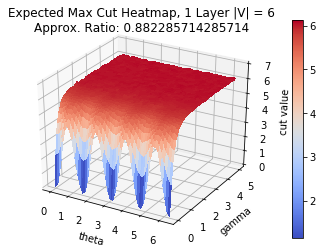

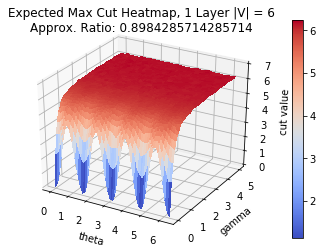

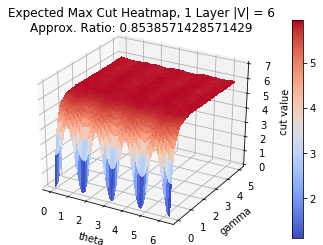

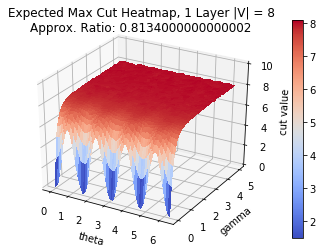

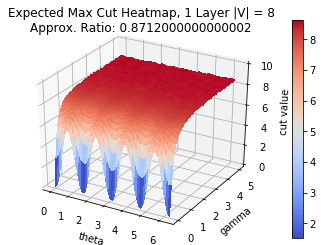

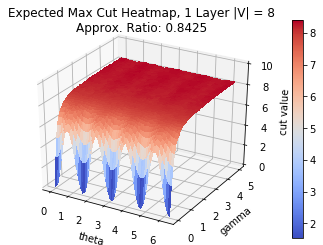

In [167]:
G6 = dict()
G8 = dict()
bounds = [(0,2*np.pi), (0,5)]#using 2pi for gamma since it saturates above ~5, and it makes a □ grid
Ns = [50,50]
numshots = 1000

##|V| == 6
tic = time.perf_counter()
for i in range(3):
    G6[i] = randomConnectedGraph(6)
    fig = plotThetaGammaHeatmap(G6[i],numshots,bounds,Ns)
    filename = 'figures/G6MaxCut' + str(i) + '.png'
    fig.savefig(filename)
    writeGraph(G6[i],'graphs/G6PlotGraph'+str(i)+'.adjlist')
toc = time.perf_counter()

print("time to generate all 6 vertex plots: ", toc - tic, " seconds")
    
    
##|V| == 8
tic = time.perf_counter()
for i in range(3):
    G8[i] = randomConnectedGraph(8)
    fig = plotThetaGammaHeatmap(G8[i],numshots,bounds,Ns)
    filename = 'figures/G8MaxCut' + str(i) + '.png'
    fig.savefig(filename)
    writeGraph(G8[i],'graphs/G8PlotGraph'+str(i)+'.adjlist')
toc = time.perf_counter()

print("time to generate all 8 vertex plots: ", toc - tic, " seconds")
    


50


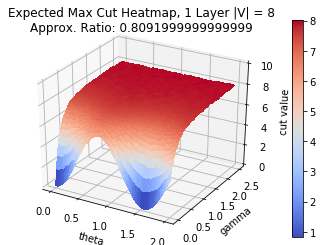

In [168]:
bounds = [(0,2), (0,2.5)]
Ns = [50,50]
numshots = 1000
fig = plotThetaGammaHeatmap(G8[0],numshots,bounds,Ns)
filename = 'figures/G8MaxCutSmallRegion.png'
fig.savefig(filename)
writeGraph(G8[i],'graphs/G8PlotGraphSmallRegion.adjlist')

In [87]:
G = randomConnectedGraph(6)
numshots = 1
bounds = [(0,6), (0.01,5)]
Ns = [2, 2]
depth = 1
opt = optimizeThetaGamma(G,numshots,depth,bounds,Ns)

theta, gamma = opt[0]
print("Best (Theta, Gamma): (", theta, ", ", gamma, ")")
print("Best Cut: ", opt[1])

theta step:  6.0
gamma step:  4.99
(slice(0, 6, 6.0), slice(0.01, 5, 4.99))
thetas:  [0.]
gammas:  [0.01]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
thetas:  [0.]
gammas:  [0.01]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.00497508 0.        ]
[0.99004983 0.00497508 0.0049750

thetas:  [0.]
gammas:  [0.01005469]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
[0.98999569 0.00500215 0.00500215 0.        ]
thetas:  [3.90625e-06]
gammas:  [0.0100625]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[1.00000000e+00 1.52587891e-11]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.        ]
[0.98998796 0.00500602 0.00500602 0.

[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
[0.98998804 0.00500598 0.00500598 0.        ]
thetas:  [7.62939453e-09]
gammas:  [0.01006245]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[1.00000000e+00 5.82076609e-17]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
[0.989988 0.005006 0.005006 0.      ]
thetas:  [3.05175781e-08]
gammas:  [0.01006244]
[1.00000000e+00 9.31322575e-16]
[1.00000000e+00 9.31322575e-16]
[1.00000000e+00 9.31322575e-16]
[1.00000000e+00 9.31322575e-16]
[1.00000000e

TypeError: cannot unpack non-iterable numpy.float64 object

time to generate all 8 vertex plots:  3420.555831359001  seconds


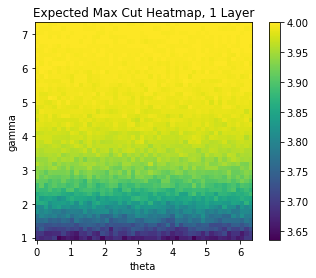

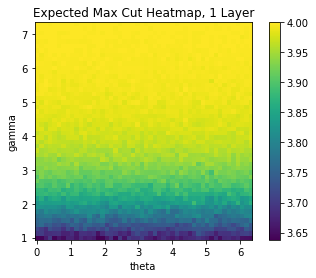

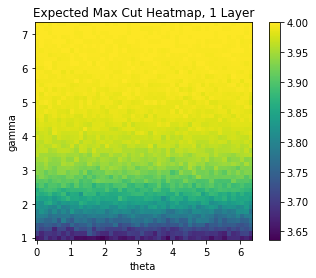

In [88]:
##|V| == 8
tic = time.perf_counter()
for i in range(3):
    G8[i] = randomConnectedGraph(8)
    fig = plotThetaGammaHeatmap(G,numshots,bounds,Ns)
    filename = 'figures/G8MaxCut' + str(i) + '.png'
    fig.savefig(filename)
    writeGraph(G8[i],'graphs/G8PlotGraph'+str(i)+'.adjlist')
toc = time.perf_counter()

print("time to generate all 8 vertex plots: ", toc - tic, " seconds")
    


13
time to generate  8  vertex plot:  558.4028147149984  seconds
13
time to generate  16  vertex plot:  1013.2497045380005  seconds
13
time to generate  32  vertex plot:  1777.5422815579986  seconds
13
time to generate  64  vertex plot:  3473.196620161001  seconds
13
time to generate  128  vertex plot:  6856.658243613001  seconds
13
time to generate  256  vertex plot:  13595.084822286  seconds
13
time to generate  512  vertex plot:  26933.181841933998  seconds
13
time to generate  1024  vertex plot:  57403.20445573202  seconds


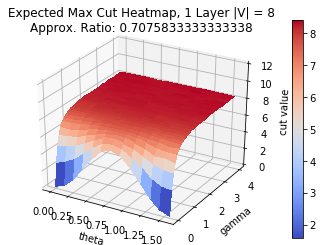

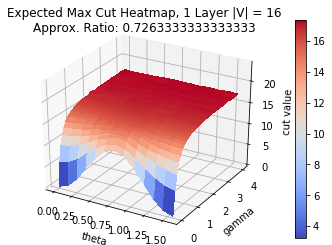

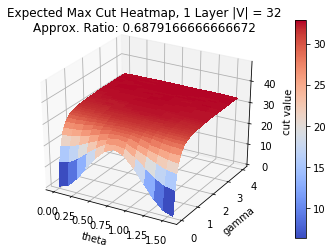

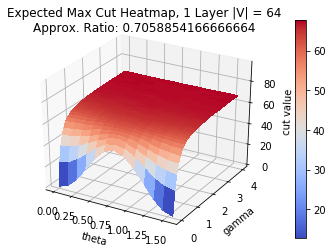

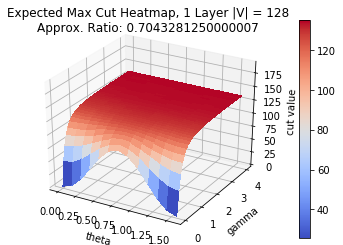

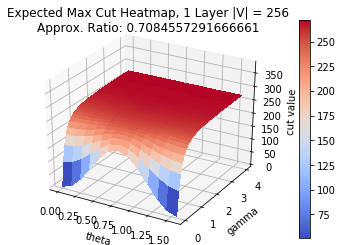

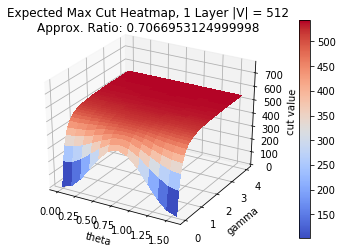

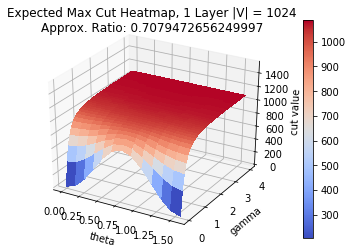

In [110]:
Gpow2 = dict()
bounds = [(0,np.pi/2), (0,4)]#using 2pi for gamma since it saturates above ~5, and it makes a □ grid
Ns = [13,40]
numshots = 1000

##|V| == 2**i

for i in range(3,11):
    tic = time.perf_counter()
    Gpow2[i] = randomConnectedGraph(2**i)
    fig = plotThetaGammaHeatmap(Gpow2[i],numshots,bounds,Ns)
    filename = 'figures/Gpow2MaxCut' + str(i) + '.png'
    fig.savefig(filename)
    writeGraph(Gpow2[i],'graphs/Gpow2PlotGraph'+str(i)+'.adjlist')
    toc = time.perf_counter()
    print("time to generate ", 2**i, " vertex plot: ", toc - tic, " seconds")


In [27]:
g = randomConnectedGraph(6)
bounds = [(0,np.pi/2), (0,4)]
Ns = [5,5]
depths = [1,2,3]
numshots = 10
tic = time.perf_counter()
fig = plotDepthPerformance(g,numshots,depths,bounds,Ns)
toc = time.perf_counter()
print("Time to generate depth plot on 6 vertices: ", (toc - tic), " seconds")
plt.show()

on depth  1
on depth  2
on depth  3


AttributeError: module 'numpy' has no attribute 'figure'

In [105]:
def randomBitVectorApproximationRatio(G,numshots):
    n = G.number_of_nodes()
    print(n)
    cuts = np.zeros(numshots)
    for i in range(numshots):
        vec = np.random.randint(2,size=n)
        cuts[i] = graphCutBin(G,vec)
    
    meanCut = np.mean(cuts)
    approx_ratio = meanCut / (3/2 * n)
    return approx_ratio

In [106]:
g = randomConnectedGraph(4)
randomBitVectorApproximationRatio(g,1000)

4


0.494

In [107]:
def aGateOnlyApproximationRatio(G, numshots):
    theta = np.pi/4
    n = G.number_of_nodes()
    circ = Circuit(n)
    #TODO: Add capability of random shuffling of keys for random layer ordering
    #add coinflip gates
    for bit in range(n):
        gate = getAnsatzGate1bit(bit,theta)
        circ.addGate(gate)
    cut = computeCircuitCuts(circ,G,numshots)
    print(cut)
    return (cut / (3*n/2)), circ
    

In [108]:
g = randomConnectedGraph(128)
cut, circ = aGateOnlyApproximationRatio(g,1000)
randomBitVectorApproximationRatio(g,1000)

95.92199999999967
128


0.4970677083333333

In [40]:
theta = np.pi/4
np.array([[np.cos(theta)**2, np.sin(theta)**2],[np.sin(theta)**2, np.cos(theta)**2]])

array([[0.5, 0.5],
       [0.5, 0.5]])

In [109]:
print(cut)

print("Matrix:\n", circ.gates[127].bits)
print(circ.fireShot())

0.4995937499999983
Matrix:
 [127]
[1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0.]


In [16]:
colors = getEdgeColoring(G);
colordict = colors2dict(colors)
for i in range(10):
    randi = np.random.randint(5)
    print(randi)

1
1
0
4
0
3
3
3
3
2


In [26]:
G2 = randomConnectedGraph(8)
numshots = 100
bounds = [(0,np.pi/2),(0,4)]
Ns = [5,5]
optimizeThetaGammaBAB(G2,numshots,bounds,Ns)

[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.        ]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39269908]
[1.57079633 0.39

(array([1.57079633, 0.39269908, 2.        , 4.        ]),
 -8.61,
 array([[[[[1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633]],
 
          [[1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633]],
 
          [[1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
           [1.57079633, 1.57079633, 1.57079633, 1.57

In [34]:
numshots = 1000
depth = 2
x = opt[0]
params = (G, numshots, depth)
cutval = _optimization_function(x,*params)
print(cutval)

-68.61800000000007


In [35]:
68/96

0.7083333333333334

In [3]:
float('inf') == np.inf

True

In [6]:
testgate = getAnsatzGate2bit(0,1,np.inf)

In [9]:
testgate.matrix

array([[0. , 0. , 0. , 0. ],
       [0.5, 1. , 0. , 0.5],
       [0.5, 0. , 1. , 0.5],
       [0. , 0. , 0. , 0. ]])

In [10]:
testgate2 = getAnsatzGate2bit(0,1,100)

In [12]:
testgate2.matrix

array([[3.72007598e-44, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e-01, 1.00000000e+00, 0.00000000e+00, 5.00000000e-01],
       [5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 5.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.72007598e-44]])

In [5]:
G = randomConnectedGraph(64)
circ = getEmbeddedCircuit(G,np.pi/4,np.inf,case='largest_only')

In [6]:
computeCircuitCuts(circ,G,1000)

62.687999999999995

In [7]:
circ2 = getEmbeddedCircuit(G,np.pi/4,np.inf,case='sorted')
computeCircuitCuts(circ2,G,10000)

68.40849999999993

In [8]:
circ3 = getEmbeddedCircuit(G,0,np.inf,case='largest_only')
computeCircuitCuts(circ3,G,1000)

62.404

In [39]:
circ4 = getEmbeddedCircuit(G,0,np.inf,case='sorted')
computeCircuitCuts(circ4,G,10000)

68.45990000000025

In [27]:
theta = 0
gamma = np.inf
circ5 = getLiteEmbeddedCircuit(G,0,np.inf,case='sorted')
#circ6 = getLiteEmbeddedCircuit(G,0,np.inf,case='sorted')
#circ5.appendCircuit(circ6)
#circ5.appendCircuit(circ6)
#circ5.appendCircuit(circ6)


In [28]:
computeCircuitCuts(circ5,G,1000)

68.37200000000006

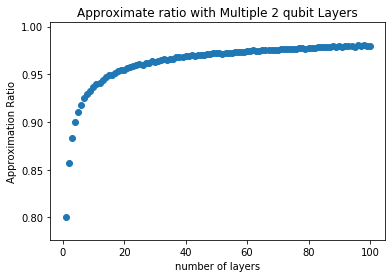

In [65]:
k = 2
G = randomConnectedGraph(64,k=k)
numlayers = 100
cutsbylayers = np.zeros(numlayers)
layers = range(numlayers)
circ = Circuit(64)
circuitLayer = getLiteEmbeddedCircuit(G,0,np.inf,'sorted')
for layer in layers:
    circ.appendCircuit(circuitLayer)
    cutsbylayers[layer] = computeCircuitCuts(circ,G,1000)
    
cutsbylayers = cutsbylayers/(k/2*64)
layers = np.array([i+1 for i in range(numlayers)])
plt.scatter(layers,cutsbylayers)
plt.title("Approximate ratio with Multiple 2 qubit Layers")
plt.xlabel("number of layers")
plt.ylabel("Approximation Ratio")
plt.show()


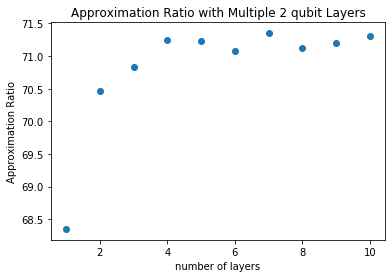

In [37]:
numlayers = 10
cutsbylayers = np.zeros(numlayers)
layers = range(numlayers)
circ = Circuit(64)
circuitLayer = getEmbeddedCircuit(G,0,np.inf,'sorted')
for layer in layers:
    circ.appendCircuit(circuitLayer)
    cutsbylayers[layer] = computeCircuitCuts(circ,G,1000)
    
layers = np.array([i+1 for i in range(numlayers)])
plt.scatter(layers,cutsbylayers)
plt.title("Max Cut with Multiple 2 qubit Layers")
plt.xlabel("number of layers")
plt.ylabel("Approximation Ratio")
plt.show()

In [40]:
68/96

0.7083333333333334

In [43]:
testgate = getAnsatzGate2bit(0,1,100)
print(testgate.matrix)

[[3.72007598e-44 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.00000000e-01 1.00000000e+00 0.00000000e+00 5.00000000e-01]
 [5.00000000e-01 0.00000000e+00 1.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.72007598e-44]]


In [42]:
testgate2 = getAnsatzGate2bit(0,1,np.inf)
print(testgate2.matrix)

[[0.  0.  0.  0. ]
 [0.5 1.  0.  0.5]
 [0.5 0.  1.  0.5]
 [0.  0.  0.  0. ]]


In [44]:
68/96

0.7083333333333334

In [45]:
71.5/96

0.7447916666666666

In [50]:
115.5/(6/2*64)

0.6015625

In [67]:
qaoaRODs = [(2*p+1)/(2*p+2) for p in range(1,101)]

Text(0, 0.5, 'Approximation Ratio')

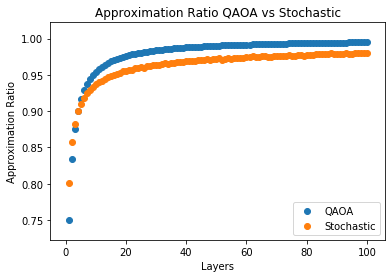

In [68]:
plt.scatter(range(1,101),qaoaRODs,label='QAOA')
plt.scatter(range(1,101),cutsbylayers,label='Stochastic')
plt.legend()
plt.title("Approximation Ratio QAOA vs Stochastic")
plt.xlabel("Layers")
plt.ylabel("Approximation Ratio")